<a href="https://colab.research.google.com/github/mandavi-singh/Quantitative-Finance-Projects/blob/main/Credit_risk_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE



## **Load and Inspect Data**

In [ ]:
df = pd.read_csv('credit_risk_dataset.csv')

print(df.head())

   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
None


In [ ]:
df = df.drop_duplicates()

In [ ]:
df = df.dropna()

In [ ]:
print(df.isnull().sum())

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [ ]:
print(df.describe())

         person_age  person_income  person_emp_length     loan_amnt  \
count  28501.000000   2.850100e+04       28501.000000  28501.000000   
mean      27.738676   6.665441e+04           4.790148   9658.533034   
std        6.316166   6.237603e+04           4.157462   6329.604672   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.950000e+04           2.000000   5000.000000   
50%       26.000000   5.600000e+04           4.000000   8000.000000   
75%       30.000000   8.000000e+04           7.000000  12500.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   28501.000000  28501.000000         28501.000000   
mean       11.045385      0.217115             0.169517   
std         3.230748      0.412289             0.106410   
min         5.420000      0.000000             0.000000   
25%         7.900000      0.000000             0.090000   
50%   

In [ ]:
def grab_col_names(dataframe, cat_th=10, car_th=20):


    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

cat_cols, cat_but_car, num_cols = grab_col_names(df)


Observations: 28501
Variables: 12
cat_cols: 5
num_cols: 7
cat_but_car: 0
num_but_cat: 1


In [ ]:
print(df['loan_status'].value_counts())

loan_status
0    22313
1     6188
Name: count, dtype: int64


In [ ]:
print(df.columns)

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')


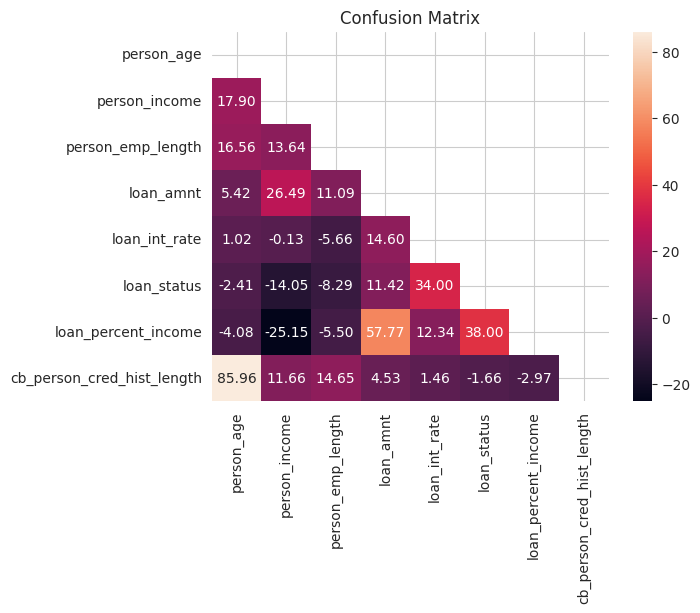

['cb_person_cred_hist_length']

In [ ]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):

    numeric_dataframe = dataframe.select_dtypes(include=['number'])

    corr = numeric_dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

    if plot:
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(corr * 100, annot= True, fmt='.2f', mask=mask)
        plt.title('Confusion Matrix')
        plt.show()

    return drop_list

high_correlated_cols(df, plot=True)

## **Handle Missing Values**

In [ ]:
df = df.dropna(subset=['loan_status'])

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


In [ ]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
for col in num_cols:
    if col != "loan_status":
      print(col, check_outlier(df, col))

person_age True
person_income True
person_emp_length True
loan_amnt False
loan_int_rate False
loan_percent_income True
cb_person_cred_hist_length True


In [ ]:
temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12),
                           height=500, width=1000))
target=df.loan_status.value_counts(normalize=True)
target.rename(index={1:'Default',0:'non default'},inplace=True)
pal, color=['#016CC9','#DEB078'], ['#8DBAE2','#EDD3B3']
fig=go.Figure()
fig.add_trace(go.Pie(labels=target.index, values=target*100, hole=.45,
                     showlegend=True,sort=False,
                     marker=dict(colors=color,line=dict(color=pal,width=2.5)),
                     hovertemplate = "%{label} Accounts: %{value:.2f}%<extra></extra>"))
fig.update_layout(template=temp, title='Target Distribution',
                  legend=dict(traceorder='reversed',y=1.05,x=0),
                  uniformtext_minsize=15, uniformtext_mode='hide',width=700)
fig.show()

In [ ]:
import plotly.tools as tls
import plotly.offline as py
df_good = df.loc[df["loan_status"] == 1]['person_age'].values.tolist()
df_bad = df.loc[df["loan_status"] == 0]['person_age'].values.tolist()
df_age = df['person_age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Loan status = 1"
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Loan status = 0"
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

/usr/local/lib/python3.11/dist-packages/plotly/tools.py:455: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
trace0 = go.Bar(
    x = df[df["loan_status"]== 1]["person_home_ownership"].value_counts().index.values,
    y = df[df["loan_status"]== 1]["person_home_ownership"].value_counts().values,
    name='Loan status = 1'
)

#Second plot
trace1 = go.Bar(
    x = df[df["loan_status"]== 0]["person_home_ownership"].value_counts().index.values,
    y = df[df["loan_status"]== 0]["person_home_ownership"].value_counts().values,
    name="Loan status = 0"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Housing Distribuition'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Housing-Grouped')

In [ ]:
trace0 = go.Bar(
    x = df[df["loan_status"]== 1]["loan_grade"].value_counts().index.values,
    y = df[df["loan_status"]== 1]["loan_grade"].value_counts().values,
    name='Loan status = 1'
)

#Second plot
trace1 = go.Bar(
    x = df[df["loan_status"]== 0]["loan_grade"].value_counts().index.values,
    y = df[df["loan_status"]== 0]["loan_grade"].value_counts().values,
    name="Loan status = 0"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Loan grade'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Loan grade')


In [ ]:
trace0 = go.Bar(
    x = df[df["loan_status"]== 1]["loan_intent"].value_counts().index.values,
    y = df[df["loan_status"]== 1]["loan_intent"].value_counts().values,
    name='Loan status = 1'
)

#Second plot
trace1 = go.Bar(
    x = df[df["loan_status"]== 0]["loan_intent"].value_counts().index.values,
    y = df[df["loan_status"]== 0]["loan_intent"].value_counts().values,
    name="Loan status = 0"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Loan intent'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Loan intent')

/tmp/ipython-input-72-798992073.py:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/tmp/ipython-input-72-798992073.py:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/tmp/ipython-input-72-798992073.py:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.


/tmp/ipython-input-72-798992073.py:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the n

<Figure size 640x480 with 0 Axes>

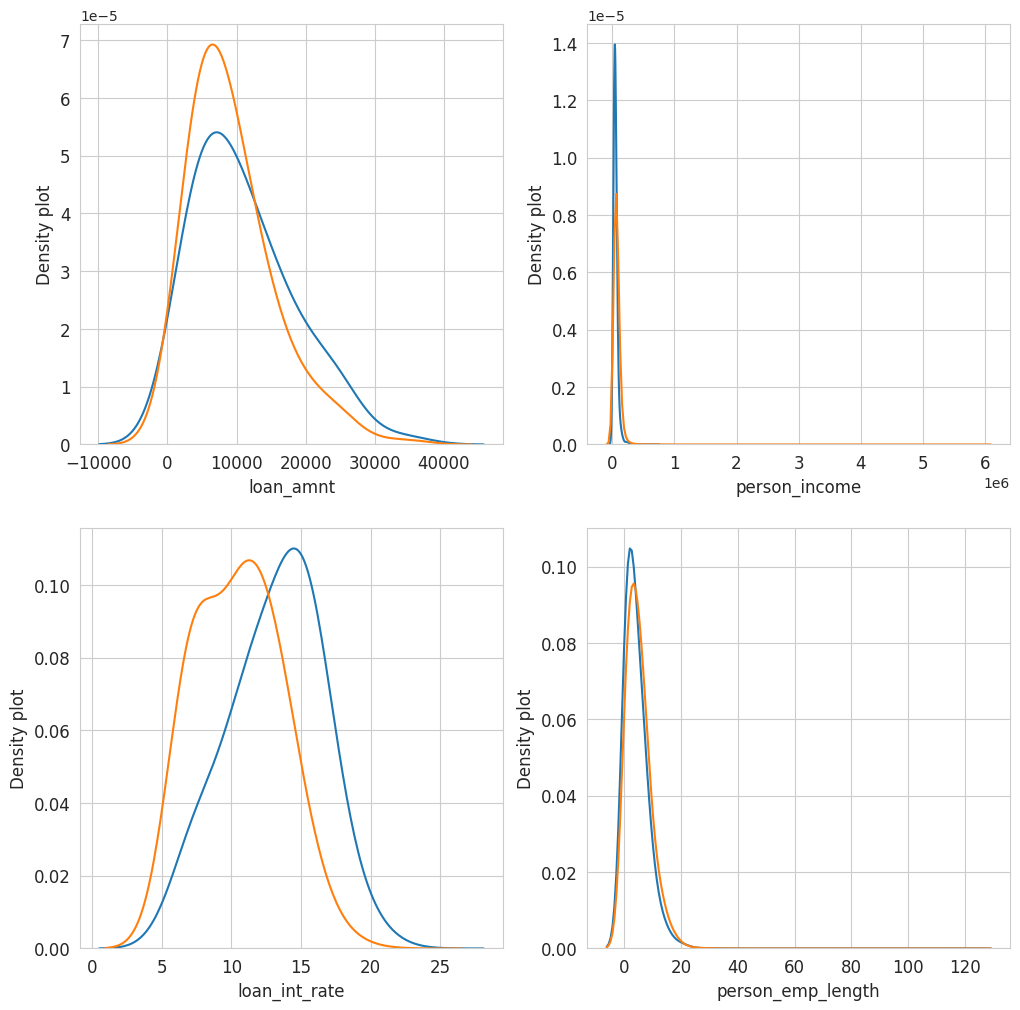

In [ ]:
def plot_distribution_comp(var,nrow=2):

    i = 0
    t1 = df.loc[df['loan_status'] != 0]
    t0 = df.loc[df['loan_status'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();
var = ['loan_amnt','person_income','loan_int_rate', 'person_emp_length']
plot_distribution_comp(var,nrow=2)

# **Encode Categorical Variables**

In [ ]:

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

print(df.head())


   person_age  person_income  person_home_ownership  person_emp_length  \
0          22          59000                      3              123.0   
1          21           9600                      2                5.0   
2          25           9600                      0                1.0   
3          23          65500                      3                4.0   
4          24          54400                      3                8.0   

   loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_status  \
0            4           3      35000          16.02            1   
1            1           1       1000          11.14            0   
2            3           2       5500          12.87            1   
3            3           2      35000          15.23            1   
4            3           2      35000          14.27            1   

   loan_percent_income  cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                          1           

# **Split Features & Target**

In [ ]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

print(X.shape, y.shape)

(28501, 11) (28501,)


# **Handle Imbalance**


In [ ]:
# Split first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("Original training set shape:", y_train.value_counts())
print("Resampled training set shape:", pd.Series(y_train_res).value_counts())


Original training set shape: loan_status
0    17850
1     4950
Name: count, dtype: int64
Resampled training set shape: loan_status
0    17850
1    17850
Name: count, dtype: int64


# **Train Models**
Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]


Decision Tree


In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train_res, y_train_res)
y_pred_dt = dt.predict(X_test_scaled)
y_prob_dt = dt.predict_proba(X_test_scaled)[:, 1]


XGBoost


In [ ]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_res, y_train_res)
y_pred_xgb = xgb.predict(X_test_scaled)
y_prob_xgb = xgb.predict_proba(X_test_scaled)[:, 1]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[18:14:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




LightGBM


In [ ]:
lgbm = LGBMClassifier()
lgbm.fit(X_train_res, y_train_res)
y_pred_lgbm = lgbm.predict(X_test_scaled)
y_prob_lgbm = lgbm.predict_proba(X_test_scaled)[:, 1]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



[LightGBM] [Info] Number of positive: 17850, number of negative: 17850
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 35700, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)

# Predictions
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]


# **Evaluate Models**

In [ ]:
models = {
    'Logistic Regression': (y_test, y_pred_lr, y_prob_lr),
    'Decision Tree': (y_test, y_pred_dt, y_prob_dt),
    'Random Forest': (y_test, y_pred_rf, y_prob_rf),
    'XGBoost': (y_test, y_pred_xgb, y_prob_xgb),
    'LightGBM': (y_test, y_pred_lgbm, y_prob_lgbm)
}

for name, (y_true, y_pred, y_prob) in models.items():
    print(f"===== {name} =====")
    print(classification_report(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_prob))
    print("\n")


===== Logistic Regression =====
              precision    recall  f1-score   support

           0       0.92      0.78      0.84      4463
           1       0.49      0.76      0.59      1238

    accuracy                           0.77      5701
   macro avg       0.70      0.77      0.72      5701
weighted avg       0.83      0.77      0.79      5701

ROC-AUC: 0.8419579475399416


===== Decision Tree =====
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      4463
           1       0.69      0.76      0.72      1238

    accuracy                           0.87      5701
   macro avg       0.81      0.83      0.82      5701
weighted avg       0.88      0.87      0.88      5701

ROC-AUC: 0.8332867587997814


===== Random Forest =====
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      4463
           1       0.92      0.73      0.81      1238

    accuracy                          

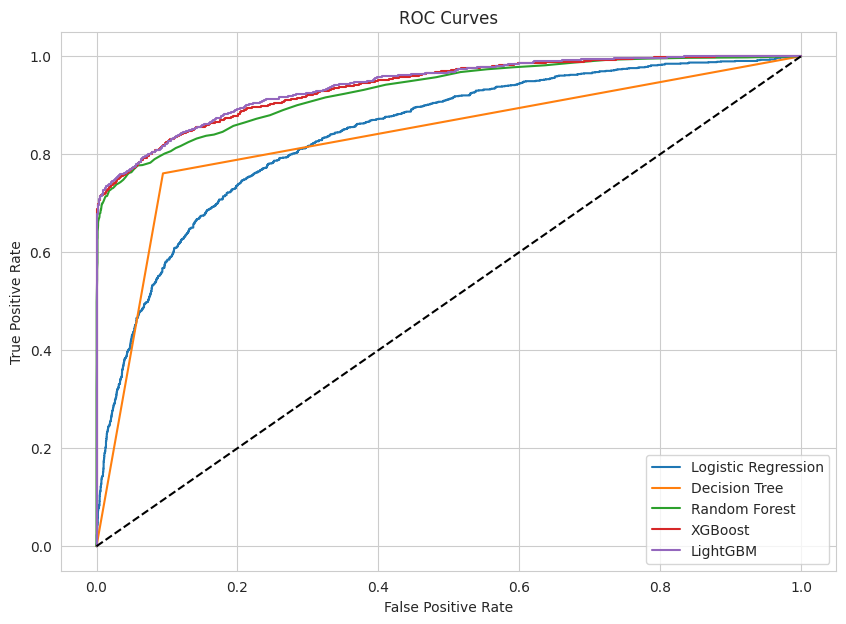

In [ ]:
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_prob_lgbm)

plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_dt, tpr_dt, label='Decision Tree')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot(fpr_lgbm, tpr_lgbm, label='LightGBM')
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


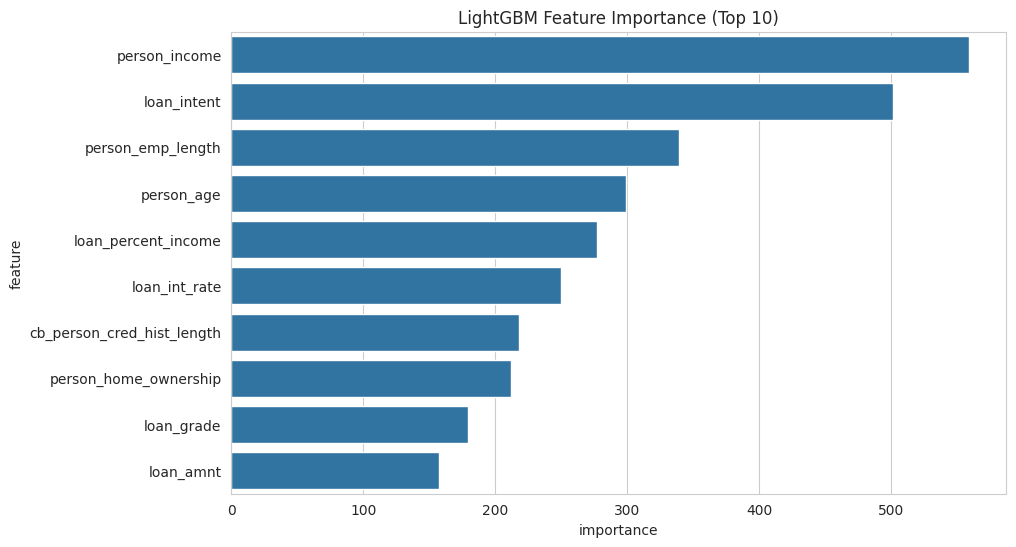

In [ ]:
lgbm_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgbm.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=lgbm_importance.head(10), x='importance', y='feature')
plt.title('LightGBM Feature Importance (Top 10)')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


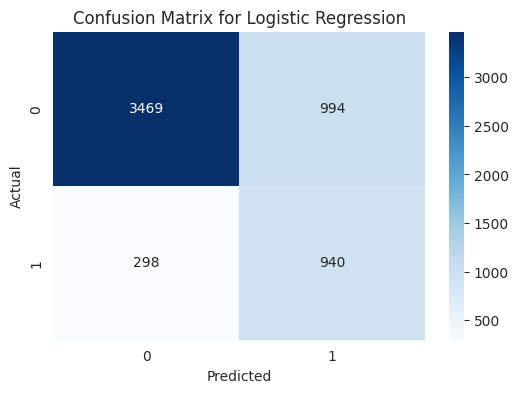

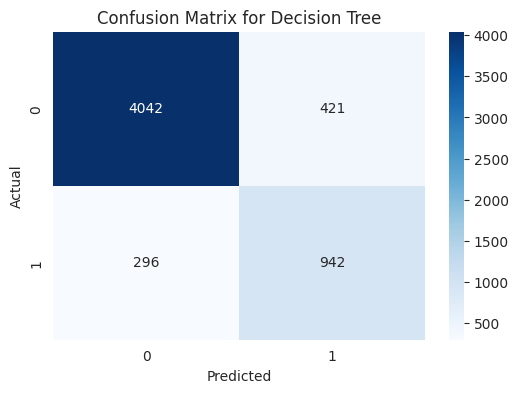

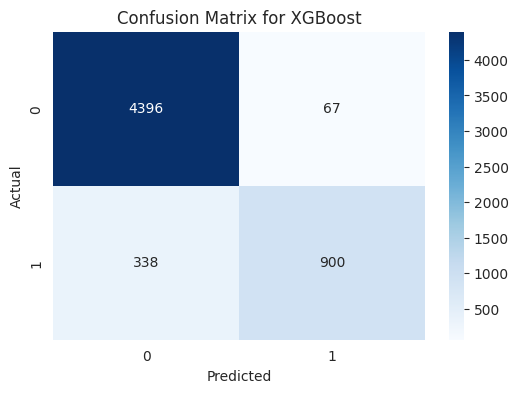

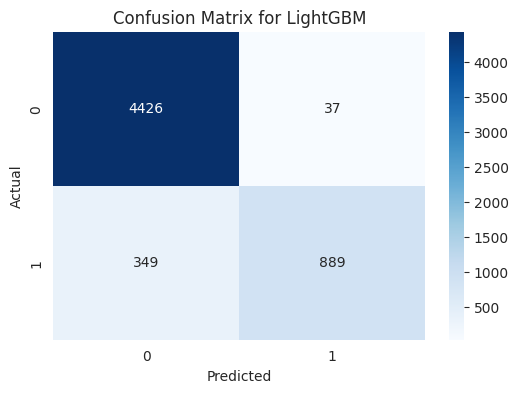

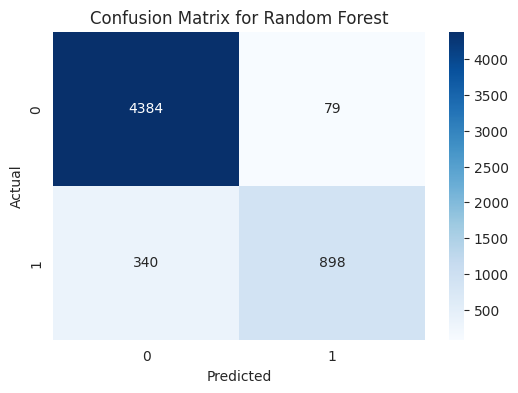

In [ ]:
# Logistic Regression
plot_confusion_matrix(y_test, y_pred_lr, 'Logistic Regression')

# Decision Tree
plot_confusion_matrix(y_test, y_pred_dt, 'Decision Tree')

# XGBoost
plot_confusion_matrix(y_test, y_pred_xgb, 'XGBoost')

# LightGBM
plot_confusion_matrix(y_test, y_pred_lgbm, 'LightGBM')
#Random Forest
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest')


In [ ]:

models = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


all_models = {
    'Logistic Regression': (y_pred_lr, y_prob_lr),
    'Decision Tree': (y_pred_dt, y_prob_dt),
    'Random Forest': (y_pred_rf, y_prob_rf),
    'XGBoost': (y_pred_xgb, y_prob_xgb),
    'LightGBM': (y_pred_lgbm, y_prob_lgbm)
}


for name, (y_pred, y_prob) in all_models.items():
    models.append(name)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    roc_auc_scores.append(roc_auc_score(y_test, y_prob))


In [ ]:
model_perfs = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1': f1_scores,
    'ROC-AUC': roc_auc_scores
}).sort_values('Accuracy', ascending=False).reset_index(drop=True)

print(model_perfs)


                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
0             LightGBM  0.932293   0.960043  0.718094  0.821627  0.940700
1              XGBoost  0.928960   0.930714  0.726979  0.816327  0.938113
2        Random Forest  0.926504   0.919140  0.725363  0.810835  0.928710
3        Decision Tree  0.874233   0.691123  0.760905  0.724337  0.833287
4  Logistic Regression  0.773373   0.486039  0.759289  0.592686  0.841958


In [ ]:

model_perfs.style.background_gradient(cmap='Blues').format(precision=3)


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,LightGBM,0.932,0.960,0.718,0.822,0.941
1,XGBoost,0.929,0.931,0.727,0.816,0.938
2,Random Forest,0.927,0.919,0.725,0.811,0.929
3,Decision Tree,0.874,0.691,0.761,0.724,0.833
4,Logistic Regression,0.773,0.486,0.759,0.593,0.842


In [ ]:
def plot_importance(model, features, num=None, save=False, title="Feature Importance"):

    if num is None:
        num = len(features.columns)

    feature_imp = pd.DataFrame({
        "Value": model.feature_importances_,
        "Feature": features.columns
    })

    plt.figure(figsize=(10, min(0.4*num + 4, 15)))
    sns.set(font_scale=1)
    sns.barplot(
        x="Value",
        y="Feature",
        data=feature_imp.sort_values(by="Value", ascending=False).head(num),
        palette='viridis'
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()




/tmp/ipython-input-90-1216993986.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




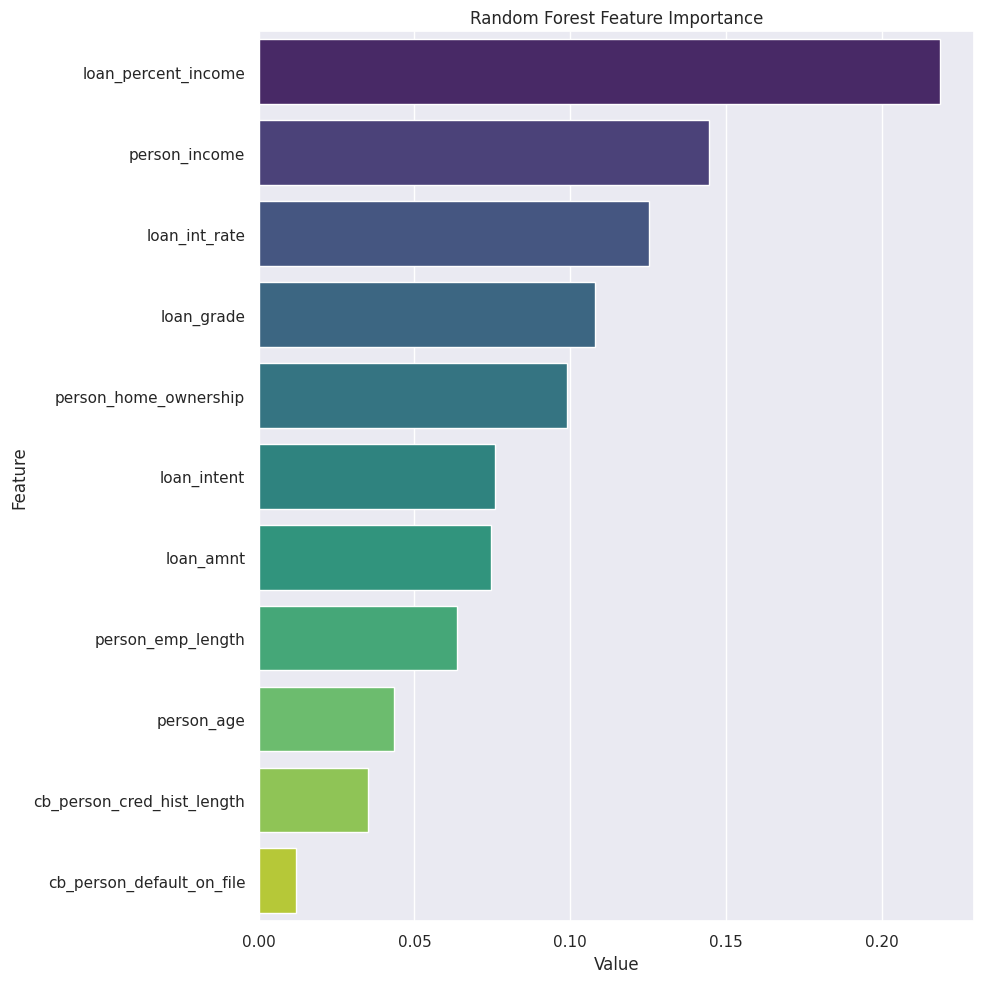

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

plot_importance(rf, X, num=15, title="Random Forest Feature Importance")
